# Kaggle: Digit Recognizer

## 1. Load libraries

In [1]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt

## 2. Explore the data

The input format is CSV. Each column is a pixel position, except for the first one which is the label column. Each row is a sample.

In [2]:
train_df = pd.read_csv('../data/train.csv')

n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

Number of training samples: 42000
Number of training pixels: 784
Number of classes: 10


In [3]:
train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_df = pd.read_csv('../data/test.csv')

n_test = len(test_df)
n_pixels = len(test_df.columns)

print('Number of train samples: {0}'.format(n_test))
print('Number of test pixels: {0}'.format(n_pixels))

Number of train samples: 28000
Number of test pixels: 784


In [5]:
test_df


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Display some images

3, 4, 1, 2, 8, 3, 5, 4


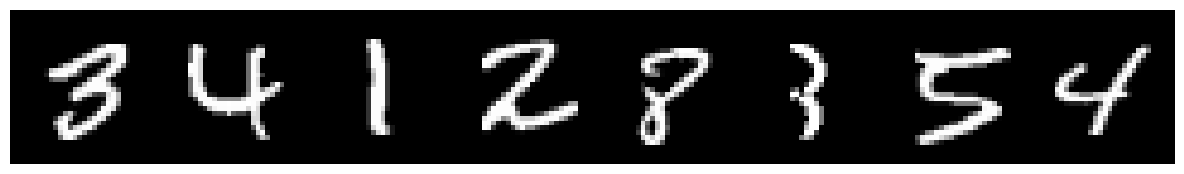

In [6]:
random_sel = np.random.randint(n_train, size=8) # randomly choose rows (samples)

grid = torchvision.utils.make_grid(
    torch.Tensor(
        (train_df.iloc[random_sel, 1:]/255.).values.reshape((-1, 28, 28))
    ).unsqueeze(1), nrow=8)

plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')

### Histogram of label distribution

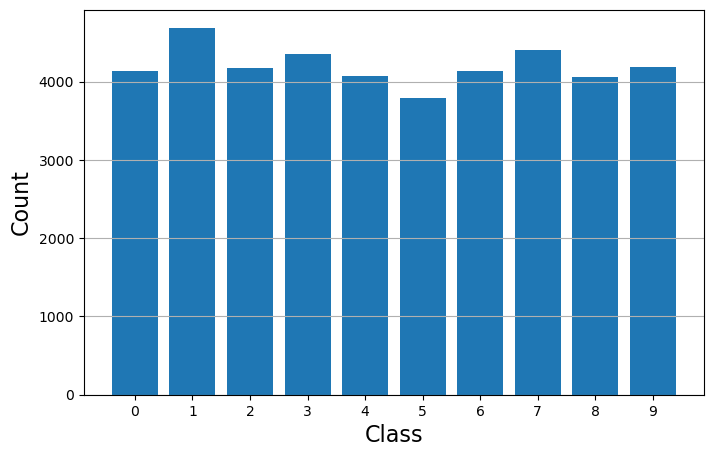

In [7]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(train_df['label'].value_counts().index, train_df['label'].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid('on', axis='y')

In [8]:
test_df.values.reshape(-1,28,28).astype(np.uint8)[:,:,:,None].shape

(28000, 28, 28, 1)

## 3. Data loader for PyTorch

In [9]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        # Initialize the dataset.
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.n_pixels = 28 * 28
        
        if len(self.data.columns) == self.n_pixels:
            # Test data
            self.X = self.data.values.reshape((-1, 28, 28)).astype(np.uint8)[:, :, :, None]
            self.y = None
        else:
            # Training data
            self.X = self.data.iloc[:, 1:].values.reshape((-1, 28, 28)).astype(np.uint8)[:, :, :, None]
            self.y = torch.from_numpy(self.data.iloc[:, 0].values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        
        if self.y is not None: # training set
            features = self.X[idx]
            target = self.y[idx]
            
            if self.transform: 
                features = self.transform(features)        
            return features, target
        
        else: # test set - no labels
            features = self.X[idx] 

            if self.transform:
                features = self.transform(features)
            return features

In [10]:
# Loading datasets 
train_dataset = CustomDataset('../data/train.csv', transform= transforms.Compose(
                            [transforms.ToTensor(), 
                             transforms.Normalize(mean=(0.5,), std=(0.5,))
                            ]))

test_dataset = CustomDataset('../data/test.csv', transform= transforms.Compose(
                            [transforms.ToTensor(), 
                             transforms.Normalize(mean=(0.5,), std=(0.5,))
                            ]))


In [11]:
train_dataset.y.shape

torch.Size([42000])

In [12]:
# Defining iterative dataloaders 
batch_size = 100

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size, shuffle=False)

type(train_loader)

torch.utils.data.dataloader.DataLoader

In [13]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)


In [14]:
images

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

In [15]:
labels

tensor([6, 3, 0, 3, 7, 8, 0, 6, 4, 4, 7, 8, 9, 5, 4, 5, 1, 7, 4, 4, 4, 4, 5, 0,
        9, 4, 3, 6, 0, 8, 3, 4, 4, 8, 4, 1, 0, 0, 9, 6, 9, 0, 8, 6, 6, 8, 4, 4,
        1, 6, 1, 9, 8, 5, 9, 4, 1, 0, 5, 6, 1, 1, 0, 4, 4, 7, 4, 2, 4, 5, 3, 3,
        5, 9, 0, 0, 1, 8, 0, 8, 7, 8, 4, 1, 9, 8, 4, 4, 9, 3, 1, 1, 0, 6, 5, 1,
        4, 1, 9, 3])

## 4. The network
Define the CNN net structure.

In [16]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x     

In [17]:
# Define the model
model = Net()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.003) 

# Define the loss function
criterion = nn.CrossEntropyLoss()

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

/var/folders/_r/625gcwy16mqds803054mbq_00000gn/T/ipykernel_24188/4122321177.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


In [18]:
for child in model.children():
    print(child)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=

## 5. Training and Evaluation

In [19]:
def train(epoch, total_epochs, all_losses):
    model.train()  # set the model to the train mode
    epoch_loss = 0.0  # for computing the average loss over the epoch
    total_batches = len(train_loader)

    for batch_idx, (data, target) in enumerate(train_loader):
         # get the inputs; [data, target]
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward() #backward pass: computes the gradients
        optimizer.step() # update weights
            
        # Accumulate the loss
        epoch_loss += loss.item()

        # Report the loss every few steps
        if batch_idx % 100 == 99:  # Print every 100 mini-batches
            print(f"Epoch [{epoch + 1}/{total_epochs}, Batch {batch_idx + 1}/{total_batches}]")

    average_epoch_loss = epoch_loss / total_batches
    all_losses.append(average_epoch_loss)
    print(f"Average Loss for Epoch {epoch + 1}: {average_epoch_loss:.3f}")

    return all_losses




Epoch [1/3, Batch 100/420]
Epoch [1/3, Batch 200/420]
Epoch [1/3, Batch 300/420]
Epoch [1/3, Batch 400/420]
Average Loss for Epoch 1: 0.198
Epoch [2/3, Batch 100/420]
Epoch [2/3, Batch 200/420]
Epoch [2/3, Batch 300/420]
Epoch [2/3, Batch 400/420]
Average Loss for Epoch 2: 0.080
Epoch [3/3, Batch 100/420]
Epoch [3/3, Batch 200/420]
Epoch [3/3, Batch 300/420]
Epoch [3/3, Batch 400/420]
Average Loss for Epoch 3: 0.065
[0.19801667939117623, 0.08030028718834122, 0.06462670366080212]


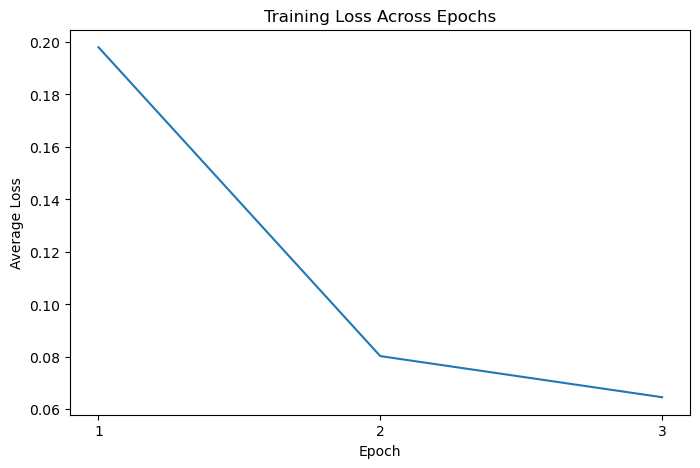

In [20]:
# Number of epochs
total_epochs = 3
all_losses = [] # this keeps tracks of the average loss in each epoch. it starts with an empty list but is given to
# the train function iteratively so that it can add average losses. 

for epoch in range(total_epochs):
    all_losses = train(epoch, total_epochs, all_losses)

print(all_losses)
# Plot the loss across epochs

epoch_list = range(1,len(all_losses)+1)
plt.plot(epoch_list, all_losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Across Epochs')
plt.xticks(epoch_list)
plt.show()

## 6. Prediction on the test set

In [38]:
def prediction(data_loader):
    model.eval() # set the model to the evaluation mode
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [40]:
test_pred = prediction(test_loader)
print(test_pred)

tensor([[2],
        [0],
        [9],
        ...,
        [3],
        [9],
        [2]])


### Output formatting for updating to Kaggle

In [58]:
out_df = pd.DataFrame(np.concatenate((np.arange(1,len(test_pred)+1)[:,None], test_pred.numpy()), axis=1),
                      columns=["ImageId", "Label"])

In [59]:
out_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [60]:
# Save
out_df.to_csv('submission.csv', index=False)